In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import trange,tqdm

In [2]:

import warnings
warnings.filterwarnings('ignore')

In [3]:
629145480/150/1000

4194.3032

In [ ]:
# %%time
df = pd.read_csv('data/train.csv', dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

In [ ]:
print(df.shape)
df.head()

In [ ]:
from pyts.image import GramianAngularField, MarkovTransitionField, RecurrencePlot
import matplotlib.pyplot as plt
from skimage.transform import resize

def extract_features(x, method='GAF', image_size=224, graph=False):
    #TODO cmap
    if method == 'GAF':
        transformer = GramianAngularField(image_size=image_size)
    elif method == 'MTF':
        transformer = MarkovTransitionField(image_size=image_size)
    elif method == 'RP':
        transformer = RecurrencePlot(dimension=1, percentage=10)
        
    x = transformer.fit_transform(x[None,:])
    x = resize(x, (1,image_size, image_size))
    return x

def make_pics(x, step_length=1000, method = 'GAF', cmap='rainbow', path = None, additions = ''):
    if path is None:
        path = "data/images_2/"
    path += method
    if not os.path.isdir(path):
        os.mkdir(path)
    
    # Reshaping and approximate standardization with mean 5 and std 3.
    temp = (x - 5 ) / 3
    
    for i in trange(x.shape[0]//(step_length)):                
        file = os.path.join(path, additions + '_' + str(i*step_length) + '.png')
        if not os.path.isfile(file):
            image_data = extract_features(temp[i:i+step_length,0],method = method)
            plt.imsave(file, image_data[0,:,:], cmap=cmap)

make_pics(df.to_numpy(),additions = 'train')

In [17]:
import glob
def make_label_df(df,addition = 'train'):
    lst = []
    for file in tqdm(glob.glob('data/images_2/GAF/' + addition +'_*.png')):
        idx = int(file.split('_')[-1].split('.')[0])
        assert type(df.iloc[idx,1]) == np.float32, idx

        lst.append({"name":file,'label':np.float32(df.iloc[idx,1]),'idx':int(idx)})
#         break
    print(lst[0],len(lst))
    df= pd.DataFrame().from_dict(lst)
    df.to_csv('data/labels_df_' + addition + '.csv')
    return df
labels_df = make_label_df(df)

labels_df.head()

100%|██████████| 629145/629145 [00:15<00:00, 40299.95it/s]


{'name': 'data/images_2/GAF/train_511621000.png', 'label': 4.4568977, 'idx': 511621000} 629145


,idx,label,name
0,511621000,4.456898,data/images_2/GAF/train_511621000.png
1,3880000,0.461499,data/images_2/GAF/train_3880000.png
2,306548000,0.335896,data/images_2/GAF/train_306548000.png
3,610626000,2.951097,data/images_2/GAF/train_610626000.png
4,415963000,0.884398,data/images_2/GAF/train_415963000.png


In [ ]:
labels_df.to_csv('data/labels_df_train.csv')

In [5]:
labels_df = pd.read_csv('data/labels_df_train.csv')
labels_df.head()

,Unnamed: 0,idx,label,name
0,0,511621000,4.456898,data/images_2/GAF/train_511621000.png
1,1,3880000,0.461499,data/images_2/GAF/train_3880000.png
2,2,306548000,0.335896,data/images_2/GAF/train_306548000.png
3,3,610626000,2.951097,data/images_2/GAF/train_610626000.png
4,4,415963000,0.884398,data/images_2/GAF/train_415963000.png


In [6]:
labels_df.label.plot(kind='box')

In [7]:
from fastai.vision import *

tfms = get_transforms(do_flip=True)

In [8]:
second_earthquake = int(50085877/1000)+1
data = (ImageList.from_df(labels_df,"",'name') #Where to find the data? -> in path and its subfolders
        .split_by_idx(range(second_earthquake))#How to split in train/valid? -> use the folders
        .label_from_df('label')
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch

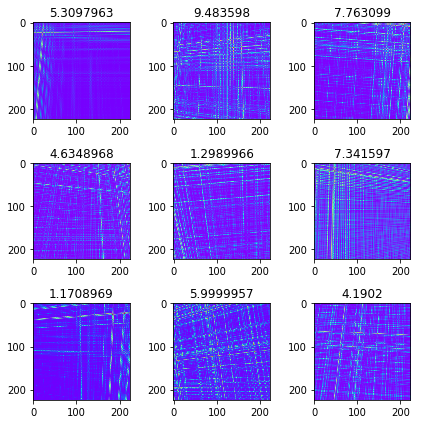

In [9]:
data.show_batch(3, figsize=(6,6), hide_axis=False)

In [10]:

learn = cnn_learner(data, models.resnet50, metrics=[mse])
# learn.load('GAF-learner-full-64')

In [11]:
learn.load('GAF-learner-full-224-fit5-....')
learn.freeze_to(0)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


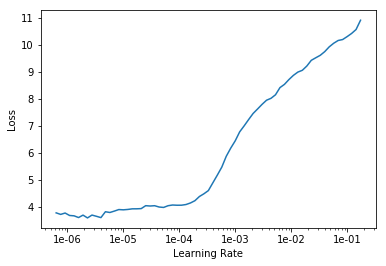

In [64]:
learn.lr_find()
learn.recorder.plot()

In [12]:
learn.fit(1,1e-6)

epoch,train_loss,valid_loss,mean_squared_error,time
0,2.967450,3.665932,3.665932,1:16:23


In [13]:
learn.validate()

[3.6659317, tensor(3.6659)]

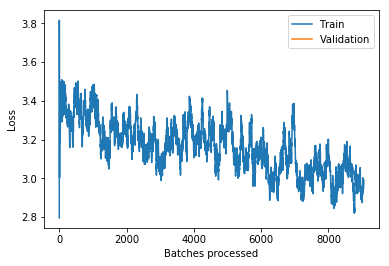

In [14]:
learn.recorder.plot_losses()

In [68]:
learn.save('GAF-learner-full-224-fit6-')
# learn.export()

In [ ]:
learn.fit_one_cycle(2,1e-4)

In [ ]:
learn.validate()

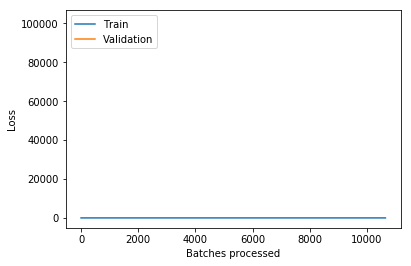

In [40]:
learn.recorder.plot_losses()

In [ ]:
learn.save('GAF-learner-full-2')

In [126]:
mdl = learn.model

In [127]:
# Load submission file
submission = pd.read_csv('data/sample_submission.csv', index_col='seg_id', dtype={"time_to_failure": np.float32})

# Load each test data, create the feature matrix, get numeric prediction
for i, seg_id in enumerate(tqdm(submission.index)):
#     print(i)
    seg = pd.read_csv('data/test/' + seg_id + '.csv')
    x = seg['acoustic_data'].values
    x = torch.tensor(create_X(x))[None,:,:].to(torch.device('cuda'))#.view(1,-1,:)
    pred = mdl(x).cpu().detach().numpy()[0]
    submission.time_to_failure[i] = pred
#     break

submission.head()

# # Save

# 

100%|██████████| 2624/2624 [00:59<00:00, 44.34it/s]


,time_to_failure
seg_id,
seg_00030f,5.424631
seg_0012b5,5.698467
seg_00184e,5.698063
seg_003339,5.692963
seg_0042cc,5.623507


In [128]:
submission.to_csv('submission.csv')